In [13]:
# Problem 1:
# Partially observable expectation maximization using two agents(blue and yellow) on a 2-D matrix
# with a Gaussian mixture of blue and yellow distributions used to drop samples on the grid that the agents have to look for.
#
# Methodology:
# Goal of Blue Agent: find and sit on square of maximal blue reward (peak of blue Gaussian).
# Goal of Yellow Agent: find and sit on square of maximal yellow reward (peak of yellow Gaussian).
#
# At each time step, a random sample is taken from distribution and dropped on grid.
# At each time step, expectation maximization is performed until convergence and the predicted points of
# peak blue and yellow are reported to the agents.
# At each time step, agents update their policies to take a step towards current perceived peak.
#
# We could compare expectation maximization to alternative methods of belief update and see what allows agents
# to converge to Gaussian peaks the fastest.


In [25]:
%matplotlib inline
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import stats
from matplotlib.patches import Ellipse
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
import random
import math
from scipy.stats import ks_2samp

In [29]:
def estimateMeanConvergence(move, i, my_centers, agentR, agentB, max_iter, X_old = None):
    # move distributions?
#     move = random.randint(0, 1)
    print(f"Did actually move? {(lambda move:'YES' if move == 1 else 'NO')(move)}")
    my_centers = ((my_centers[0][0] + 1*move, my_centers[0][1] + 4*move),
                  (my_centers[1][0] - 3*move, my_centers[1][1] - 1*move))
    print("iteration: %d"%i)
    # draw samples
    X, y_true = make_blobs(n_samples=10000, centers=my_centers,
                       cluster_std=1.5, random_state=i)
    
    
    # stack observations if new data from same distribution (in order to incorporate more data into estimate of mean).
    # otherwise, only use new data.
    #
    # note: assumes independence of x and y
    if i!= 0:
        # fit GMM using previous means as initial means
        gmm = GaussianMixture(n_components=2, means_init = gmm.means_,
                          max_iter=max_iter).fit(X)
        # extract predicted labels
        labels = gmm.predict(X)
        ks_df = pd.DataFrame(np.column_stack((X, labels)))
        
        print(ks_2samp(ks_df[ks_df[2] == 1][0], ks_df_OLD[ks_df_OLD[2] == 1][0])) # TEMP
        
        # if estimated underlying distributions have not changed, stack data.
        #
        # note: assumes independence of x and y (i.e. uses univariate ks test)
        if ks_2samp(ks_df[ks_df[2] == 1][0], ks_df_OLD[ks_df_OLD[2] == 1][0])[1] > .99 and\
            ks_2samp(ks_df[ks_df[2] == 1][1], ks_df_OLD[ks_df_OLD[2] == 1][1])[1] > .99 and\
            ks_2samp(ks_df[ks_df[2] == 0][0], ks_df_OLD[ks_df_OLD[2] == 0][0])[1] > .99 and\
            ks_2samp(ks_df[ks_df[2] == 0][0], ks_df_OLD[ks_df_OLD[2] == 0][0])[1] > .99:
                # stack observations
                X = np.vstack((X_old, X)) 
        
    # fit GMM
    gmm = GaussianMixture(n_components=2, init_params='kmeans',
                          max_iter=max_iter).fit(X)
    
    # extract predicted labels
    labels = gmm.predict(X)
    
    # create ks df for next iteration
    ks_df_OLD = pd.DataFrame(np.column_stack((X, labels)))

    
    # update target means for agents to seek
    B_mean_estimate, R_mean_estimate = tuple(gmm.means_[0]), tuple(gmm.means_[1])
    
    
    ## move agents towards respective estimated means 
    #
    # calc distances from agents to respective means
    distanceR = (sum((np.array(R_mean_estimate) - np.array(agentR))**2))**(1/2) # unweighted....no log prob...
    distanceB = (sum((np.array(B_mean_estimate) - np.array(agentB))**2))**(1/2) # unweighted....no log prob...
    
    # calculate angles
    angle_degreeR = math.degrees(math.atan2(R_mean_estimate[1] - agentR[1],
                                            R_mean_estimate[0] - agentR[0]))
    angle_degreeB = math.degrees(math.atan2(B_mean_estimate[1] - agentB[1],
                                            B_mean_estimate[0] - agentB[0]))
    
    # scale (if set to 1, agent will move all the way to mean of respective distribution) 
    scaleR = .5
    scaleB = .5
    
    # set new agent location (red)
    agentR = agentR[0] + scaleR * distanceR * math.cos(angle_degreeR * math.pi / 180),\
             agentR[1] + scaleR * distanceR * math.sin(angle_degreeR * math.pi / 180)
    # set new agent location (blue)
    agentB = agentB[0] + scaleB * distanceB * math.cos(angle_degreeB * math.pi / 180),\
             agentB[1] + scaleB * distanceB * math.sin(angle_degreeB * math.pi / 180)
    
    
    # Plot points, assigning GMM labels as colors
    fig = plt.figure(figsize=(9, 9))
    plt.axis([-20, 20, -20, 20])
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=24, cmap='jet')
    
    # add updated points to plot
    plt.plot(agentR[0], agentR[1], marker='s', linestyle='-', color='y') 
    plt.plot(agentB[0], agentB[1], marker='s', linestyle='-', color='g') 
    
    # make data copy for next iteration
    X_old = np.copy(X) 
    #Increment Counter
    i+=1
    return X_old,i
    
    #print(gmm.lower_bound_)
    

In [30]:
# Set initial values

random.seed(1)
max_iter = 100
agentR = (-25, -25) # initial location of agentR
agentB = (25, -25) # initial location of agentB
my_centers = ((-5, -5),(5, 5))
i = 0

In [32]:
move = 0

Did actually move? NO
iteration: 0


(array([[-2.65512857, -6.38986955],
        [-3.50523792, -5.8222062 ],
        [-1.59536806, -7.18154851],
        ..., 
        [-5.1404759 , -5.83056224],
        [ 7.15829622,  3.80076783],
        [ 5.51922246,  4.71062159]]), 1)

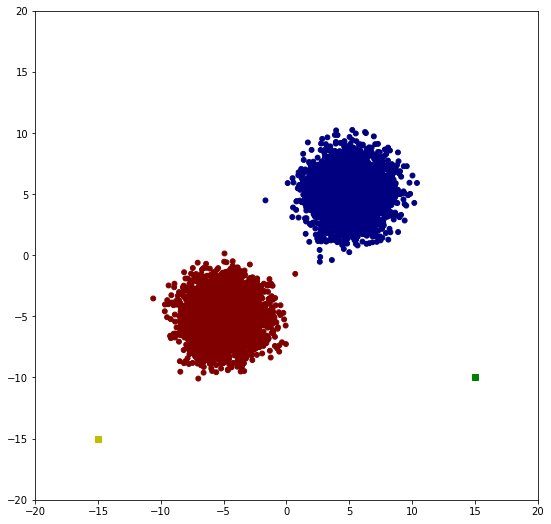

In [33]:
estimateMeanConvergence(move, i, X_old, my_centers, agentR, agentB, max_iter)

In [ ]:
# old notes...

# 1) Drop sample.
# 2) Produce initializing guess (intentionally bad/random)
# 3) Perform Expectation Maximization to update estimates until convergence.
# 4) Move Agents 1 step in direction of current mean estimates.
# 4) Drop next sample, from new distribution (generated randomly, within parameters...)
# 5) Use last convergences as new initial guesses...
# 6) Perform Expectation Maximization to update estimates until convergence.
# 7) Move Agents 1 step in direction of updated mean estimates...

# For current default, set this to run for 100 distribution movements (i.e. 100(x2) convergences, and 100(x2) steps.)



In [ ]:
# lower_bound_ : float
#Log-likelihood of the best fit of EM.

# could take step proportional to size of log-likelihood?